<h1 align="center"> The Donor's Choose challenge</h1>


![](https://cdn.donorschoose.net/images/logo/dc-logo.png)


Founded in 2000 by a high school teacher in the Bronx, DonorsChoose.org empowers public school teachers from across the country to request much-needed materials and experiences for their students. At any given time, there are thousands of classroom requests that can be brought to life with a gift of any amount.

DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.

The goal of this problem originally posted on [Kaggle](https://www.kaggle.com/c/donorschoose-application-screening) is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.

I will be doing some text cleaning, feature engineering and Neural Networks, particularly the LSTM to try and give a solution for this problem. Let's begin.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from keras.optimizers import adam, RMSprop
from keras import regularizers
import numpy as np
from sklearn.preprocessing import StandardScaler
from numpy import asarray
from keras.models import Model, Sequential
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate, Embedding, Flatten, concatenate, Dropout, Conv1D
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from time import time
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [2]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

# Processing text data

I will be using a processed csv file already available with me. But it still needs to be further changed.

Keras or any other ML library cannot accept raw text data of `essay`, or categorical variables like `school_state`. Before we build our neural net models, we need to bring this data into a format that is suitable for feeding into a model. i.e. we need to convert them into numbers.

In [3]:
df_donors = pd.read_csv('./preprocessed_data.csv')

In this data, **project_is_approved** is the target variable

In [4]:
df_donors.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


**Create Train test, CV, test sets**

In [5]:
from sklearn.model_selection import train_test_split

df_X_train_CV, df_X_test, y_train_CV, y_test = train_test_split(
    df_donors.drop('project_is_approved', axis=1),
    df_donors['project_is_approved'],
    test_size=.20)

df_X_train, df_X_CV, y_train, y_CV = train_test_split(df_X_train_CV,
                                                   y_train_CV,
                                                   test_size=0.20)

In [6]:
df_donors.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price'],
      dtype='object')

**Features**

Our data has these features. We'll process each one of them in some way.

    1 essay --> Embedding using pretrained Glove. Trainable = False
    2 school_state --> Categorical --> Embedding. Trainable = True
    3 grade_category --> Categorical --> Embedding. Trainable = True
    4 clean_category --> Categorical --> Embedding. Trainable = True
    5 clean_subcategory --> Categorical --> Embedding. Trainable = True
    6 teacher_prefix --> Categorical --> Embedding. Trainable = True
    7 teacher_number_of_previously_posted_projects --> Numerical feature.
    
Let's begin with the first and the most important feature - essay.

In [7]:
df_X_train.shape, df_X_CV.shape, df_X_test.shape

((69918, 8), (17480, 8), (21850, 8))

In [8]:
y_train.shape, y_CV.shape, y_test.shape

((69918,), (17480,), (21850,))

## 1. Essay

    step 1. Tokenize the essays
    step 2. Pad the tokenized essays so that each one of them has a fixed length
    step 3. Load the pretrained GloVe embeddings for words from the 300 dimensional version
    step 4. create an embedding matrix, which stores the 300 dim vetor for each word in the vocabulary
    step 5. Define the embedding and the LSTM layer 

In [9]:
t_essays = Tokenizer()
t_essays.fit_on_texts(df_X_train.essay.tolist())
encoded_docs_train = t_essays.texts_to_sequences(df_X_train.essay.tolist())

There are 47189 words in the vocabulary

In [10]:
vocab_size_essays = len(t_essays.word_index) + 1
print(vocab_size_essays)

47517


**obtain the tokenized essay representation for CV and Test sets**

In [11]:
encoded_docs_CV = t_essays.texts_to_sequences(df_X_CV.essay.tolist())
encoded_docs_test = t_essays.texts_to_sequences(df_X_test.essay.tolist())

**Pad the inputs**

Instead of padding all the essays (docs) with the same maximum length, let's see how the number of words in essays are distributed.

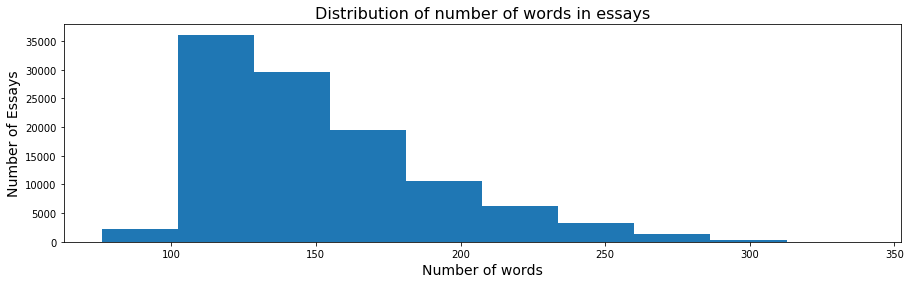

In [12]:
df_donors.essay.str.split().apply(len).plot.hist(figsize=(15,4))
plt.title('Distribution of number of words in essays', fontsize=16)
plt.xlabel('Number of words', fontsize=14)
plt.ylabel('Number of Essays', fontsize=14)
plt.show()

**The 95th percentile of #words in essays is 231**. Which means most of the essays have much lower word count than the essay with maximum word count(339) in the dataset. If we pad the lengths to `339`, most of the other essays would have redundant 0 inputs. Instead, let's keep the max length of essay inputs to 231. Doing this would also improve the training time because fewer parameters would have to be trained.

In [13]:
pctile_95_wc = df_donors.essay.str.split().apply(len).quantile(.95)
max_wc = df_donors.essay.str.split().apply(len).max()

print('95th Percentile word count in Essays:', pctile_95_wc)
print('Maximum word count in essays:', max_wc)

95th Percentile word count in Essays: 231.0
Maximum word count in essays: 339


In [14]:
padded_docs_train = pad_sequences(encoded_docs_train,
                                  maxlen=int(pctile_95_wc),
                                  padding='post',
                                  truncating='post')
padded_docs_CV = pad_sequences(encoded_docs_CV,
                               maxlen=int(pctile_95_wc),
                               padding='post',
                               truncating='post')
padded_docs_test = pad_sequences(encoded_docs_test,
                                 maxlen=int(pctile_95_wc),
                                 padding='post',
                                 truncating='post')

As expected, the each essay in each of the sets has an input length of 231.

In [15]:
padded_docs_train.shape ,padded_docs_CV.shape, padded_docs_test.shape

((69918, 231), (17480, 231), (21850, 231))

**Load pretrained Glove embedding for essays**

In [16]:
# load the whole embedding into memory
embeddings_index = dict()
errors = 0

f = open('glove.840B.300d.txt')
for line in f:
    try:
        values = line.split()
        word = values[0]
        coefs = asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except:
        errors += 1
        print(errors, end='\r')
        continue
    
f.close()

print('Loaded %s word vectors.' % len(embeddings_index))

In [17]:
# f = open('embeddings_index.pkl', 'rb')
# embeddings_index = pickle.load(f)
# f.close()

In [18]:
len(embeddings_index)

2195884

In [19]:
type(embeddings_index)

dict

Save the embedding_index to the disk for fast retrieval

In [20]:
import pickle
f = open('embeddings_index.pkl', 'wb')
pickle.dump(embeddings_index, f)
f.close()

**create a weight matrix**

Such that for each word in the essay vocabulary along the index, we get a 300 dimensional Glove vector along columns

In [21]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size_essays, 300))
for word, i in t_essays.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [22]:
embedding_matrix.shape

(47517, 300)

**Define the embedding layer for essays**

In [23]:
essay_input = Input(shape=(padded_docs_train.shape[1],))

e = Embedding(vocab_size_essays,
              300,
              weights=[embedding_matrix],
              input_length=padded_docs_train.shape[1],
              trainable=False,
              batch_size=64)(essay_input)

lstm_out_essay = LSTM(units=128,
                      recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.001),
                      input_shape=(padded_docs_train.shape[1], 300),
                      return_sequences=True)(e)

lstm_out_flattened = Flatten()(lstm_out_essay)

W0912 14:30:09.515259 140176581261056 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0912 14:30:09.738810 140176581261056 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0912 14:30:09.810947 140176581261056 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0912 14:30:09.839965 140176581261056 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0912 14:30:09.840799 1401765812

## 2. School state

This is a categorical variable and needs to be converted into tokens

In [24]:
t_school_state = Tokenizer()
t_school_state.fit_on_texts(df_X_train.school_state.tolist())

vocab_size_school_state = len(t_school_state.word_index) + 1

encoded_school_states_train = t_school_state.texts_to_sequences(df_X_train.school_state)
encoded_school_states_CV = t_school_state.texts_to_sequences(df_X_CV.school_state)
encoded_school_states_test = t_school_state.texts_to_sequences(df_X_test.school_state)

# Convert the above lists to numPy arrays and assign them to "padded" arrays so that it doesn't break the 
# following code

padded_school_states_train = np.array(encoded_school_states_train)
padded_school_states_CV = np.array(encoded_school_states_CV)
padded_school_states_test = np.array(encoded_school_states_test)

In [25]:
np.array(encoded_school_states_train).shape, np.array(encoded_school_states_CV).shape, np.array(encoded_school_states_test).shape

((69918, 1), (17480, 1), (21850, 1))

In [26]:
padded_school_states_train.shape, padded_school_states_CV.shape, padded_school_states_test.shape

((69918, 1), (17480, 1), (21850, 1))

In [27]:
vocab_size_school_state

52

**Define the input and embedding for the school_states variable**

In [28]:
input_layer_school_state = Input(shape=(1, ))
embedding_school_state = Embedding(vocab_size_school_state,
                                   8,
                                   input_length=1,
                                   trainable=True)(input_layer_school_state)
flatten_school_state_out = Flatten()(embedding_school_state)

## 3. project_grade_category

**Categorical variable to be converted into tokens**

In [29]:
df_donors.project_grade_category.unique()

array(['grades_prek_2', 'grades_3_5', 'grades_9_12', 'grades_6_8'],
      dtype=object)

In [30]:
t_project_grade_cat = Tokenizer(filters='')
t_project_grade_cat.fit_on_texts(df_X_train.project_grade_category.tolist())

vocab_size_project_grade_cat = len(t_project_grade_cat.word_index) + 1

encoded_project_grade_cats_train = t_project_grade_cat.texts_to_sequences(df_X_train.project_grade_category)
encoded_project_grade_cats_CV = t_project_grade_cat.texts_to_sequences(df_X_CV.project_grade_category)
encoded_project_grade_cats_test = t_project_grade_cat.texts_to_sequences(df_X_test.project_grade_category)

padded_project_grade_cats_train = np.array(encoded_project_grade_cats_train)
padded_project_grade_cats_CV = np.array(encoded_project_grade_cats_CV)
padded_project_grade_cats_test = np.array(encoded_project_grade_cats_test)

In [31]:
t_project_grade_cat.word_counts

OrderedDict([('grades_3_5', 23882),
             ('grades_prek_2', 28291),
             ('grades_9_12', 6901),
             ('grades_6_8', 10844)])

In [32]:
padded_project_grade_cats_train.shape, padded_project_grade_cats_CV.shape, padded_project_grade_cats_test.shape

((69918, 1), (17480, 1), (21850, 1))

In [33]:
encoded_project_grade_cats_train[:10], df_X_train.project_grade_category.head(10).values

([[2], [1], [1], [1], [4], [2], [1], [2], [1], [1]],
 array(['grades_3_5', 'grades_prek_2', 'grades_prek_2', 'grades_prek_2',
        'grades_9_12', 'grades_3_5', 'grades_prek_2', 'grades_3_5',
        'grades_prek_2', 'grades_prek_2'], dtype=object))

**Define the input and the embedding for project_grade_category**

In [34]:
vocab_size_project_grade_cat

5

In [35]:
input_layer_project_grade_cat = Input(shape=(1, ))
embedding_project_grade_cat = Embedding(
    vocab_size_project_grade_cat, 4,
    input_length=1)(input_layer_project_grade_cat)
flatten_project_grade_cat_out = Flatten()(embedding_project_grade_cat)

## 4. Clean categories

In [36]:
df_donors.clean_categories.nunique()

51

In [37]:
df_donors.clean_categories.head()

0         math_science
1         specialneeds
2    literacy_language
3      appliedlearning
4    literacy_language
Name: clean_categories, dtype: object

In [38]:
t_clean_category = Tokenizer()
t_clean_category.fit_on_texts(df_X_train.clean_categories.tolist())

vocab_size_clean_category = len(t_clean_category.word_index) + 1

encoded_clean_category_train = t_clean_category.texts_to_sequences(df_X_train.clean_categories)
encoded_clean_category_CV = t_clean_category.texts_to_sequences(df_X_CV.clean_categories)
encoded_clean_category_test = t_clean_category.texts_to_sequences(df_X_test.clean_categories)

max_length_clean_category = df_donors.clean_categories.str.split(' ').apply(
    len).max()

padded_clean_category_train = pad_sequences(encoded_clean_category_train,
                                           maxlen=max_length_clean_category,
                                           padding='post')
padded_clean_category_CV = pad_sequences(encoded_clean_category_CV,
                                           maxlen=max_length_clean_category,
                                           padding='post')
padded_clean_category_test = pad_sequences(encoded_clean_category_test,
                                           maxlen=max_length_clean_category,
                                           padding='post')

In [39]:
padded_clean_category_train.shape, padded_clean_category_CV.shape, padded_clean_category_test.shape

((69918, 3), (17480, 3), (21850, 3))

**Define the input and the embedding for clean_category**

In [40]:
input_layer_clean_category = Input(shape=(3,))
embedding_clean_category = Embedding(vocab_size_clean_category, 8, input_length=3)(input_layer_clean_category)
flatten_clean_category = Flatten()(embedding_clean_category)

## 5. Clean subcategories

In [41]:
df_donors.clean_subcategories.nunique()

401

In [42]:
df_donors.clean_subcategories.head()

0    appliedsciences health_lifescience
1                          specialneeds
2                              literacy
3                      earlydevelopment
4                              literacy
Name: clean_subcategories, dtype: object

In [43]:
t_clean_subcategory = Tokenizer()
t_clean_subcategory.fit_on_texts(df_X_train.clean_subcategories.tolist())

vocab_size_clean_subcategory = len(t_clean_subcategory.word_index) + 1

encoded_clean_subcategory_train = t_clean_subcategory.texts_to_sequences(df_X_train.clean_subcategories)
encoded_clean_subcategory_CV = t_clean_subcategory.texts_to_sequences(df_X_CV.clean_subcategories)
encoded_clean_subcategory_test = t_clean_subcategory.texts_to_sequences(df_X_test.clean_subcategories)

max_length_clean_subcategory = df_donors.clean_subcategories.str.split(' ').apply(
    len).max()

padded_clean_subcategory_train = pad_sequences(encoded_clean_subcategory_train,
                                           maxlen=max_length_clean_subcategory,
                                           padding='post')
padded_clean_subcategory_CV = pad_sequences(encoded_clean_subcategory_CV,
                                           maxlen=max_length_clean_subcategory,
                                           padding='post')
padded_clean_subcategory_test = pad_sequences(encoded_clean_subcategory_test,
                                           maxlen=max_length_clean_subcategory,
                                           padding='post')

In [44]:
padded_clean_subcategory_train.shape, padded_clean_subcategory_CV.shape, padded_clean_subcategory_test.shape

((69918, 3), (17480, 3), (21850, 3))

**Define the input and the embedding for clean_subcategories**

In [45]:
input_layer_clean_subcategory = Input(shape=(3, ))
embedding_clean_subcategory = Embedding(
    vocab_size_clean_subcategory, 8,
    input_length=3)(input_layer_clean_subcategory)
flatten_clean_subcategory = Flatten()(embedding_clean_subcategory)

## 6. Teacher Prefix

In [46]:
df_donors.teacher_prefix.nunique()

5

In [47]:
df_donors.teacher_prefix.head()

0    mrs
1     ms
2    mrs
3    mrs
4    mrs
Name: teacher_prefix, dtype: object

In [48]:
t_teacher_prefix = Tokenizer()
t_teacher_prefix.fit_on_texts(df_X_train.teacher_prefix.tolist())

vocab_size_teacher_prefix = len(t_teacher_prefix.word_index) + 1

encoded_teacher_prefix_train = t_teacher_prefix.texts_to_sequences(df_X_train.teacher_prefix)
encoded_teacher_prefix_CV = t_teacher_prefix.texts_to_sequences(df_X_CV.teacher_prefix)
encoded_teacher_prefix_test = t_teacher_prefix.texts_to_sequences(df_X_test.teacher_prefix)

max_length_teacher_prefix = df_donors.teacher_prefix.str.split(' ').apply(
    len).max()

padded_teacher_prefix_train = np.array(encoded_teacher_prefix_train)
padded_teacher_prefix_CV = np.array(encoded_teacher_prefix_CV)
padded_teacher_prefix_test = np.array(encoded_teacher_prefix_test)

In [49]:
padded_teacher_prefix_train.shape, padded_teacher_prefix_CV.shape, padded_teacher_prefix_test.shape

((69918, 1), (17480, 1), (21850, 1))

**Define the input and embedding for teacher_prefix** 

In [50]:
input_layer_teacher_prefix = Input(shape=(1,))
embedding_teacher_prefix = Embedding(vocab_size_teacher_prefix, 8, input_length=1)(input_layer_teacher_prefix)
flatten_teacher_prefix = Flatten()(embedding_teacher_prefix)

## 7. Other features

In [51]:
df_donors[['teacher_number_of_previously_posted_projects', 'price']].head()

,teacher_number_of_previously_posted_projects,price
0,53,725.05
1,4,213.03
2,10,329.00
3,2,481.04
4,2,17.74


In [52]:
input_layer_pp_price = Input(shape=(2,))
out_other_features = Dense(2)(input_layer_pp_price)

In [53]:
type(out_other_features)

tensorflow.python.framework.ops.Tensor

**Get input data arrays for other features**

In [54]:
other_features_train = df_X_train[['teacher_number_of_previously_posted_projects', 'price']].values
other_features_CV = df_X_CV[['teacher_number_of_previously_posted_projects', 'price']].values
other_features_test = df_X_test[['teacher_number_of_previously_posted_projects', 'price']].values

# Model 1

<img src='https://i.imgur.com/w395Yk9.png'>

**Concatenate the flattened vectors**

In [55]:
merged = concatenate([
    lstm_out_flattened, flatten_school_state_out,
    flatten_project_grade_cat_out, flatten_clean_category,
    flatten_clean_subcategory, flatten_teacher_prefix, out_other_features
])

In [56]:
type(merged)

tensorflow.python.framework.ops.Tensor

**Add the following Dense and Dropout layers**

In [57]:
x = Dense(128, activation='selu', kernel_regularizer=regularizers.l2(0.001))(merged)
x = Dropout(.5)(x)
x = Dense(64, activation='selu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(.5)(x)
x = Dense(32, activation='selu', kernel_regularizer=regularizers.l2(0.001))(x)

main_output = Dense(1, activation='sigmoid', name='main_output')(x)

W0912 14:30:46.651278 140176581261056 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3217: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


**Create a final model of the whole architecture**

In [58]:
final_model = Model(inputs=[
    essay_input, input_layer_school_state, input_layer_project_grade_cat,
    input_layer_clean_category, input_layer_clean_subcategory,
    input_layer_teacher_prefix, input_layer_pp_price
],
                    outputs=[main_output])

In [59]:
final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 231)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 231, 300)     14255100    input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (I

**Compile the model**

In [60]:
adm = adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
final_model.compile(optimizer=adm, loss='binary_crossentropy', metrics=['accuracy'])

W0912 14:30:46.777848 140176581261056 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [61]:
padded_docs_train.shape, padded_school_states_train.shape, padded_project_grade_cats_train.shape

((69918, 231), (69918, 1), (69918, 1))

**Train the model by passing the training data**

In [62]:
from tensorflow.test import is_gpu_available
is_gpu_available()

True

**standardize the numerical features**

In [63]:
def stdscale(X_train, X_CV, X_test):

    scaler = StandardScaler().fit(X_train)
    return (scaler.transform(X_train), scaler.transform(X_CV),
            scaler.transform(X_test))
other_features_train, other_features_CV, other_features_test = stdscale(
    other_features_train, other_features_CV, other_features_test)

**Function to print AUC after each epoch**

I've referred to [this](https://gist.github.com/smly/d29d079100f8d81b905e) code on GitHub and modified it slightly to work with my code.

In [64]:
import logging as l

from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback


class IntervalEvaluation(Callback):
    def __init__(self, validation_data=(), interval=10):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        #if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print('**********************','Epoch:', epoch+1, 'AUC: ', score, '*********************')
            #logging.info("interval evaluation - epoch: {:d} - score: {:.6f}".format(epoch, score))


if __name__ == '__main__':
    l.basicConfig(format='%(asctime)s %(message)s', level=l.INFO)
    ival = IntervalEvaluation(validation_data=([
                    padded_docs_CV, padded_school_states_CV,
                    padded_project_grade_cats_CV, padded_clean_category_CV,
                    padded_clean_subcategory_CV, padded_teacher_prefix_CV, other_features_CV
                ], y_CV), interval=None)

**Create a tensorboard object**

In [65]:
tb_1 = TensorBoard(log_dir="logs/{}".format(time()))

In [66]:
warnings.filterwarnings('ignore')

**Finally, we are ready to train the model**

In [67]:
%%notify

final_model.fit([
    padded_docs_train, padded_school_states_train,
    padded_project_grade_cats_train, padded_clean_category_train,
    padded_clean_subcategory_train, padded_teacher_prefix_train,
    other_features_train
], [y_train],
                epochs=20,
                batch_size=1024,validation_data=([
                    padded_docs_CV, padded_school_states_CV,
                    padded_project_grade_cats_CV, padded_clean_category_CV,
                    padded_clean_subcategory_CV, padded_teacher_prefix_CV, other_features_CV
                ], [y_CV]),
                 callbacks=[ tb_1, ival])

Train on 69918 samples, validate on 17480 samples


W0912 14:30:55.552245 140176581261056 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0912 14:30:55.553541 140176581261056 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/20
69918/69918 [==============================] - 33s 467us/step - loss: 1.1415 - acc: 0.8250 - val_loss: 0.8521 - val_acc: 0.8432
********************** Epoch: 1 AUC:  0.6995609656464212 *********************
Epoch 2/20
69918/69918 [==============================] - 29s 414us/step - loss: 0.7663 - acc: 0.8491 - val_loss: 0.7207 - val_acc: 0.8445
********************** Epoch: 2 AUC:  0.7163529835206441 *********************
Epoch 3/20
69918/69918 [==============================] - 29s 415us/step - loss: 0.6499 - acc: 0.8516 - val_loss: 0.6172 - val_acc: 0.8447
********************** Epoch: 3 AUC:  0.7321154775426431 *********************
Epoch 4/20
69918/69918 [==============================] - 29s 416us/step - loss: 0.5882 - acc: 0.8537 - val_loss: 0.5753 - val_acc: 0.8438
********************** Epoch: 4 AUC:  0.7372978563884904 *********************
Epoch 5/20
69918/69918 [==============================] - 29s 415us/step - loss: 0.5496 - acc: 0.8567 - val_loss: 0.5436 - val_a

<IPython.core.display.Javascript object>

**Model 1: Train loss**

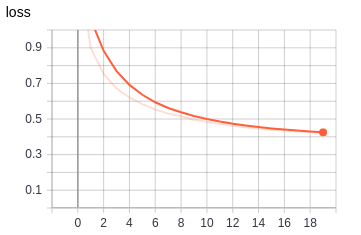

In [266]:
from IPython.display import Image
Image('model_1_training_loss.png')

**model 1: Validation loss**

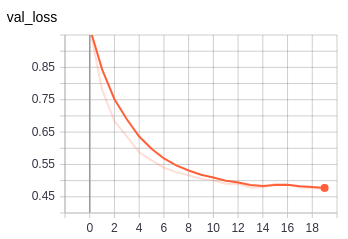

In [267]:
Image('model_1_validation_loss.png')

# Model 2

In this model, the architecture of the neural net remains the same, but the words in the Essays are filtered based on their IDF values.

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [49]:
df_X_train.essay.head()

85561     how close achievement gap students not necessa...
86620     my fourth grade students innovative creative g...
7546      the students room 61 amazing group exceptional...
102214    my students awesome despite high poverty low i...
48281     the students school arrive various degree educ...
Name: essay, dtype: object

Create a TFIDF object and fit it on the train data

In [50]:
tfidf = TfidfVectorizer()
tfidf_essay_fit = tfidf.fit_transform(df_X_train.essay)

In [51]:
tfidf.idf_.shape, len(tfidf.get_feature_names())

((47165,), 47165)

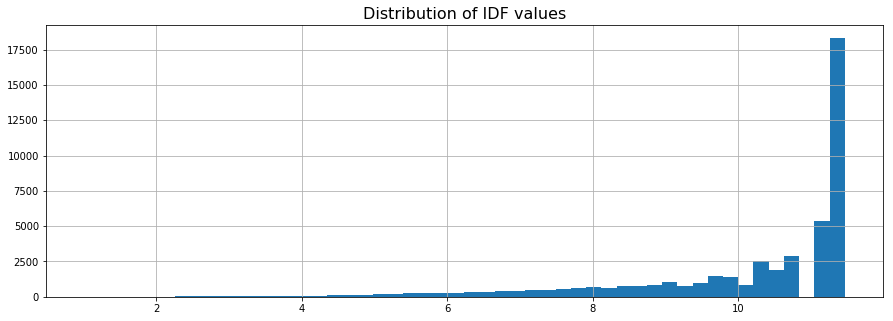

In [272]:
plt.figure(figsize=(15,5))
plt.hist(tfidf.idf_, bins=50)
plt.grid()
plt.title('Distribution of IDF values', fontsize=16)
plt.show()

The bottom 5 percentile and the last 5 percentile IDF values

In [52]:
np.percentile(tfidf.idf_, 5),np.percentile(tfidf.idf_, 95)

(6.173678496913165, 11.4619455276077)

How the IDF values are distributed across all the words in the training corpus

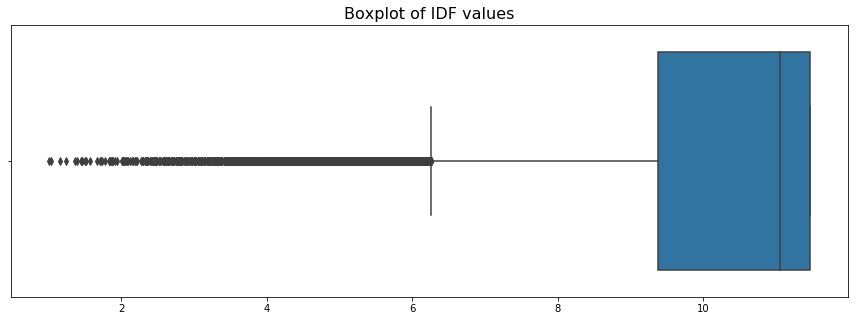

In [274]:
import seaborn as sbn
plt.figure(figsize=(15,5))
sbn.boxplot(tfidf.idf_)
plt.title('Boxplot of IDF values', fontsize=16)
plt.show()

Create a mapping for words to their IDF values

In [53]:
dict_word_to_IDF_mapping = dict(zip(tfidf.get_feature_names(), tfidf.idf_.tolist()))

**Function to remove the words with IDF values outside our thresholds (< 5 percentile and >95 percentile)**

In [54]:
def remove_extremeIDFwords(x):
    lowIDF=6.173678496913165
    highIDF=11.4619455276077
    
    filtered_words = []
    for word in x.split():
        
        try:
            idf_value = dict_word_to_IDF_mapping[word]
        except:
            continue
        
        if  (idf_value > lowIDF) and (idf_value < highIDF):
            filtered_words.append(word)
                
    return ' '.join(filtered_words)

Filter all the datasets on the IDF values using the above function 

In [55]:
df_X_train['essay_IDF'] = df_X_train.essay.map(remove_extremeIDFwords)
df_X_CV['essay_IDF'] = df_X_CV.essay.map(remove_extremeIDFwords)
df_X_test['essay_IDF'] = df_X_test.essay.map(remove_extremeIDFwords)

In [56]:
df_X_train

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,essay_IDF
85561,in,mrs,grades_6_8,2,math_science,mathematics,how close achievement gap students not necessa...,15.99,indicate disabled mildly handicapped disturban...
86620,ca,mrs,grades_3_5,0,health_sports literacy_language,health_wellness literacy,my fourth grade students innovative creative g...,49.99,collaborates beings enormous relies solely lov...
7546,ca,mr,grades_9_12,1,appliedlearning specialneeds,parentinvolvement specialneeds,the students room 61 amazing group exceptional...,393.98,61 ties ambition 61 embedded exceptionality pr...
102214,wi,mrs,grades_6_8,15,math_science,appliedsciences,my students awesome despite high poverty low i...,277.93,hey
48281,mn,mrs,grades_3_5,8,literacy_language,literacy,the students school arrive various degree educ...,132.99,degree orchestra formation
16814,ca,mrs,grades_prek_2,57,math_science,mathematics,our school diverse student population majority...,138.94,narrative frames rekenreks grouping
9222,la,mrs,grades_6_8,0,literacy_language history_civics,literature_writing socialsciences,my students academically gifted class students...,1156.47,aptitude iq tailored tap mode stifle mode comp...
31250,or,mrs,grades_3_5,2,health_sports,health_wellness,third grade special year our students no longe...,284.94,immensely vivacious failures keys jfk intellec...
38432,ga,mrs,grades_3_5,2,math_science,appliedsciences mathematics,our students live low income neighborhoods in ...,289.99,72 rising permeate minis minis minis prezi ble...
72235,mi,mrs,grades_3_5,3,literacy_language math_science,literacy mathematics,my students active lot energy they love read l...,159.43,slowly ratio globally timely fashion ratio end...


**Tokenize the essays**

Earlier, for the previous model, we did this on the entire essay. This time, we've already filtered the words based on IDF.

In [57]:
t_essays = Tokenizer()
t_essays.fit_on_texts(df_X_train.essay_IDF.tolist())
encoded_docs_train = t_essays.texts_to_sequences(df_X_train.essay_IDF.tolist())

In [58]:
vocab_size_essays = len(t_essays.word_index) + 1
print(vocab_size_essays)

26561


**obtain the tokenized essay representation for CV and Test sets**

In [59]:
encoded_docs_CV = t_essays.texts_to_sequences(df_X_CV.essay_IDF.tolist())
encoded_docs_test = t_essays.texts_to_sequences(df_X_test.essay_IDF.tolist())

**Pad the inputs**

Instead of padding all the essays (docs) with the same maximum length, let's see how the number of words in essays are distributed.

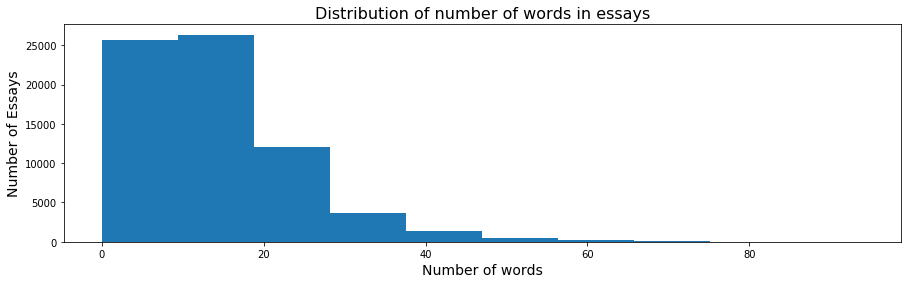

In [282]:
df_X_train.essay_IDF.str.split().apply(len).plot.hist(figsize=(15,4))
plt.title('Distribution of number of words in essays', fontsize=16)
plt.xlabel('Number of words', fontsize=14)
plt.ylabel('Number of Essays', fontsize=14)
plt.show()

**The 95th percentile of #words in essay_IDF is 33**. Which means most of the essays have much lower word count than the essay with maximum word count(101) in the dataset. If we pad the lengths to `101`, most of the other essays would have redundant 0 inputs. Instead, let's keep the max length of essay inputs to 33. Doing this would also improve the training time because less number of parameters would have to be trained.

In [60]:
pctile_95_wc = df_X_train.essay_IDF.str.split().apply(len).quantile(.95)
max_wc = df_X_train.essay_IDF.str.split().apply(len).max()

print('95th Percentile word count in Essays:', pctile_95_wc)
print('Maximum word count in essays:', max_wc)

95th Percentile word count in Essays: 33.0
Maximum word count in essays: 102


In [61]:
padded_docs_train = pad_sequences(encoded_docs_train,
                                  maxlen=int(pctile_95_wc),
                                  padding='post',
                                  truncating='post')
padded_docs_CV = pad_sequences(encoded_docs_CV,
                               maxlen=int(pctile_95_wc),
                               padding='post',
                               truncating='post')
padded_docs_test = pad_sequences(encoded_docs_test,
                                 maxlen=int(pctile_95_wc),
                                 padding='post',
                                 truncating='post')

In [62]:
padded_docs_train.shape ,padded_docs_CV.shape, padded_docs_test.shape

((69918, 33), (17480, 33), (21850, 33))

Generate the embedding matrix again, since we've retrained the `t_essays` TFIDF object.

In [63]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size_essays, 300))
for word, i in t_essays.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

**Define the embedding layer for essays**

In [64]:
essay_input = Input(shape=(padded_docs_train.shape[1], ))

e = Embedding(vocab_size_essays,
              300,
              weights=[embedding_matrix],
              input_length=padded_docs_train.shape[1],
              trainable=False,
              batch_size=64)(essay_input)

lstm_out_essay = LSTM(units=128,
                      recurrent_dropout=0.45, kernel_regularizer=regularizers.l2(0.001),
                      input_shape=(padded_docs_train.shape[1], 300),
                      return_sequences=True)(e)

lstm_out_flattened = Flatten()(lstm_out_essay)

**Concatenate the flattened vectors for model 2**

Here, note that we've only created `lstm_out_flattened` tensor again. Because the others have remained unchanged since model 1. We can use them directly as they are.

In [81]:
merged = concatenate([
    lstm_out_flattened, flatten_school_state_out,
    flatten_project_grade_cat_out, flatten_clean_category,
    flatten_clean_subcategory, flatten_teacher_prefix, out_other_features
])

In [289]:
type(merged)

tensorflow.python.framework.ops.Tensor

# Add the following Dense and Dropout layers

In [82]:
x = Dense(128, activation='selu', kernel_regularizer=regularizers.l2(0.001))(merged)
x = Dropout(.5)(x)
x = Dense(64, activation='selu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(.5)(x)
x = Dense(32, activation='selu', kernel_regularizer=regularizers.l2(0.001))(x)

main_output = Dense(1, activation='sigmoid', name='main_output')(x)

**Create a final model of the whole architecture**

In [83]:
final_model_2 = Model(inputs=[
    essay_input, input_layer_school_state, input_layer_project_grade_cat,
    input_layer_clean_category, input_layer_clean_subcategory,
    input_layer_teacher_prefix, input_layer_pp_price
],
                    outputs=[main_output])

In [84]:
final_model_2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 33)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 33, 300)      7968300     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_5 (I

## Compile the model

In [85]:
#from keras.optimizers import Adam
adm = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
final_model_2.compile(optimizer=adm, loss='binary_crossentropy', metrics=['accuracy'])

In [86]:
ival = IntervalEvaluation(validation_data=([
    padded_docs_CV, padded_school_states_CV, padded_project_grade_cats_CV,
    padded_clean_category_CV, padded_clean_subcategory_CV,
    padded_teacher_prefix_CV, other_features_CV
], y_CV),
                          interval=None)

In [87]:
tb_2 = TensorBoard(log_dir="logs/{}".format(time()))

In [88]:
%%notify

final_model_2.fit([
    padded_docs_train, padded_school_states_train,
    padded_project_grade_cats_train, padded_clean_category_train,
    padded_clean_subcategory_train, padded_teacher_prefix_train,
    other_features_train
], [y_train],
                epochs=20,
                batch_size=1024,validation_data=([
                    padded_docs_CV, padded_school_states_CV,
                    padded_project_grade_cats_CV, padded_clean_category_CV,
                    padded_clean_subcategory_CV, padded_teacher_prefix_CV, other_features_CV
                ], [y_CV]),
                 callbacks=[ival, tb_2])

Train on 69918 samples, validate on 17480 samples
Epoch 1/20
69918/69918 [==============================] - 6s 93us/step - loss: 1.5400 - acc: 0.7749 - val_loss: 0.7318 - val_acc: 0.8423
********************** Epoch: 1 AUC:  0.5851247560934565 *********************
Epoch 2/20
69918/69918 [==============================] - 5s 67us/step - loss: 0.7167 - acc: 0.8235 - val_loss: 0.5911 - val_acc: 0.8495
********************** Epoch: 2 AUC:  0.5855240671216032 *********************
Epoch 3/20
69918/69918 [==============================] - 5s 67us/step - loss: 0.6195 - acc: 0.8377 - val_loss: 0.5518 - val_acc: 0.8499
********************** Epoch: 3 AUC:  0.5973967850511249 *********************
Epoch 4/20
69918/69918 [==============================] - 5s 67us/step - loss: 0.5758 - acc: 0.8422 - val_loss: 0.5326 - val_acc: 0.8499
********************** Epoch: 4 AUC:  0.5937262711871363 *********************
Epoch 5/20
69918/69918 [==============================] - 5s 67us/step - loss: 0.5500 

<IPython.core.display.Javascript object>

**Model 2: Training loss**

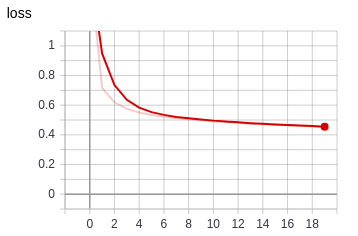

In [89]:
Image('model_2_train_loss.png')

**Model 2: validation loss**

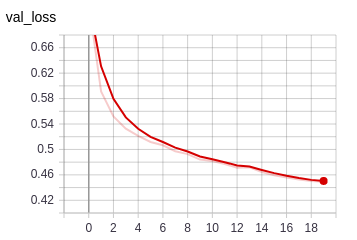

In [90]:
Image('model_2_validation_loss.png')

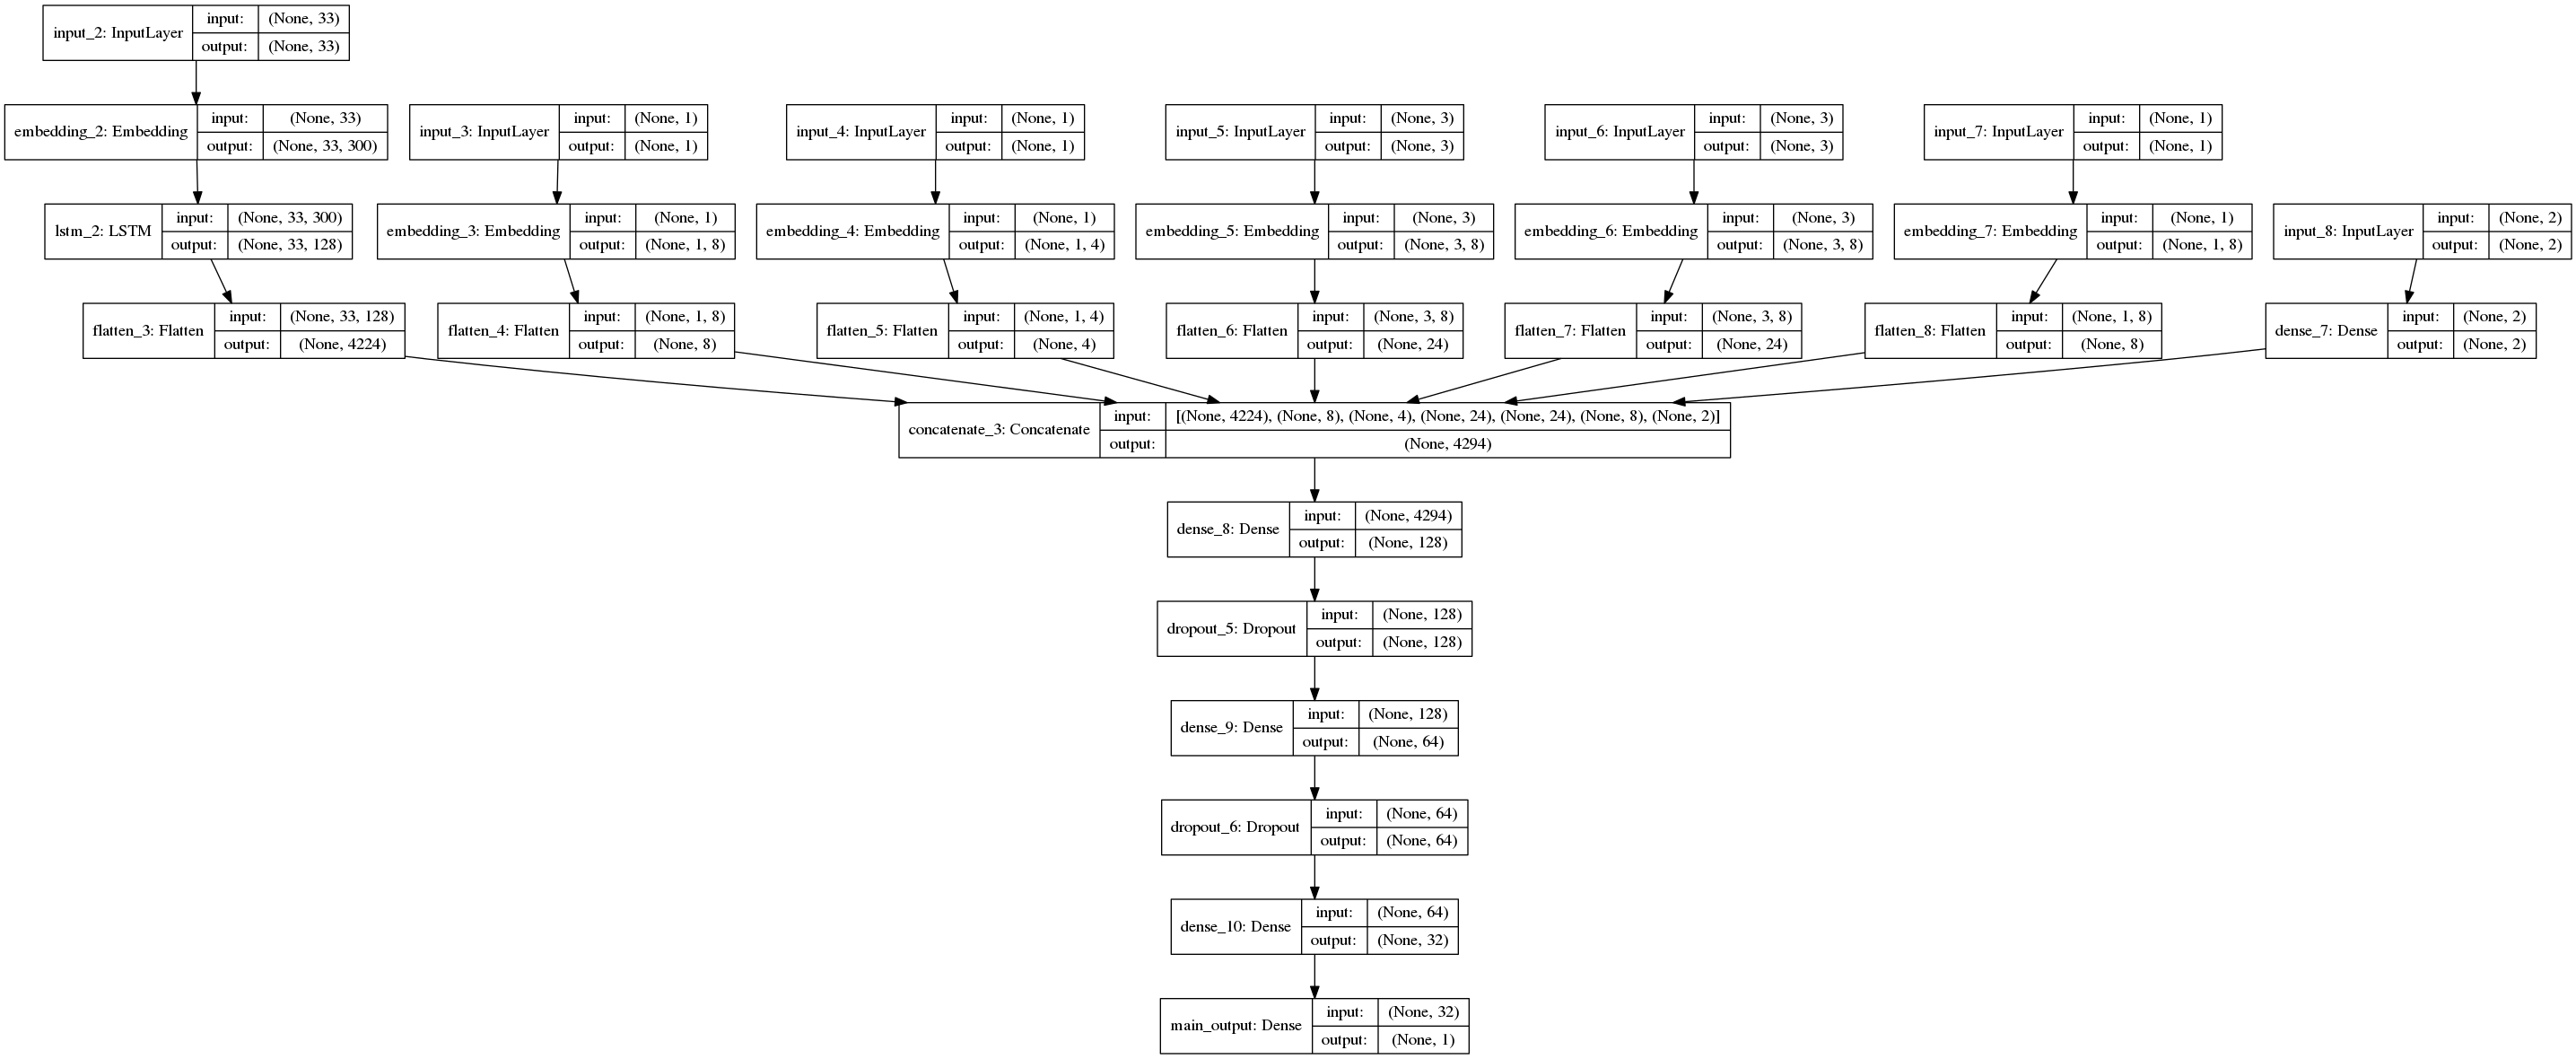

In [95]:
from keras.utils import plot_model
import pydot_ng as pydot
plot_model(final_model_2, show_shapes=True, show_layer_names=True, to_file='model_2.png')
from IPython.display import Image
Image(retina=True, filename='model_2.png')

# Model 3

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack

In [16]:
df_X_train.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'clean_categories',
       'clean_subcategories', 'essay', 'price'],
      dtype='object')

In [47]:
df_donors.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price'],
      dtype='object')

**School state 1 hot encoded**

In [17]:
vec = CountVectorizer(binary=False)

school_state_train_1hot = vec.fit_transform(df_X_train['school_state'])
school_state_CV_1hot = vec.transform(df_X_CV['school_state'])
school_state_test_1hot = vec.transform(df_X_test['school_state'])

**Teacher prefix 1 hot encoded**

In [18]:
vec = CountVectorizer(binary=False)

teacher_prefix_train_1hot = vec.fit_transform(df_X_train['teacher_prefix'])
teacher_prefix_CV_1hot = vec.transform(df_X_CV['teacher_prefix'])
teacher_prefix_test_1hot = vec.transform(df_X_test['teacher_prefix'])

In [301]:
teacher_prefix_train_1hot.toarray().shape

(69918, 5)

**Project grade category 1 hot encoded**

In [19]:
vec = CountVectorizer(binary=False)

project_grade_category_train_1hot = vec.fit_transform(df_X_train['project_grade_category'])
project_grade_category_CV_1hot = vec.transform(df_X_CV['project_grade_category'])
project_grade_category_test_1hot = vec.transform(df_X_test['project_grade_category'])

In [303]:
project_grade_category_train_1hot.toarray().shape

(69918, 4)

**clean_categories 1 hot encoded**

In [20]:
vec = CountVectorizer(binary=False)

clean_categories_train_1hot = vec.fit_transform(
    df_X_train['clean_categories'])

clean_categories_CV_1hot = vec.transform(
    df_X_CV['clean_categories'])

clean_categories_test_1hot = vec.transform(
    df_X_test['clean_categories'])

**Clean subcategories**

In [21]:
vec = CountVectorizer(binary=False)

clean_subcategories_train_1hot = vec.fit_transform(
    df_X_train['clean_subcategories'])

clean_subcategories_CV_1hot = vec.transform(
    df_X_CV['clean_subcategories'])

clean_subcategories_test_1hot = vec.transform(
    df_X_test['clean_subcategories'])

**Stack all 1 hot encoded features together**

In [22]:
other_features_train = hstack([
    school_state_train_1hot, teacher_prefix_train_1hot,
    project_grade_category_train_1hot, clean_categories_train_1hot,
    clean_subcategories_train_1hot
]).todense()

other_features_CV = hstack([
    school_state_CV_1hot, teacher_prefix_CV_1hot,
    project_grade_category_CV_1hot, clean_categories_CV_1hot,
    clean_subcategories_CV_1hot
]).todense()


other_features_test = hstack([
    school_state_test_1hot, teacher_prefix_test_1hot,
    project_grade_category_test_1hot, clean_categories_test_1hot,
    clean_subcategories_test_1hot
]).todense()


In [23]:
other_features_train.shape, other_features_CV.shape, other_features_test.shape

((69918, 99), (17480, 99), (21850, 99))

**Numerical features**

In [24]:
X_train_ppp = df_X_train[[
    'teacher_number_of_previously_posted_projects', 'price'
]].values.reshape(-1, 2)

X_CV_ppp = df_X_CV[['teacher_number_of_previously_posted_projects',
                    'price']].values.reshape(-1, 2)

X_test_ppp = df_X_test[[
    'teacher_number_of_previously_posted_projects', 'price'
]].values.reshape(-1, 2)

In [25]:
scaler = StandardScaler()

X_train_ppp = scaler.fit_transform(X_train_ppp)
X_CV_ppp = scaler.transform(X_CV_ppp)
X_test_ppp = scaler.transform(X_test_ppp)

**Stack all features together**

In [26]:
X_train = np.hstack([other_features_train, X_train_ppp])
X_CV = np.hstack([other_features_CV, X_CV_ppp])
X_test = np.hstack([other_features_test, X_test_ppp])

In [27]:
X_train = np.expand_dims(X_train,2)
X_CV = np.expand_dims(X_CV,2)
X_test = np.expand_dims(X_test,2)

In [28]:
X_train.shape

(69918, 101, 1)

In [29]:
inp_conv =  Input(shape=(101,1),name='all_features')
x1 = Conv1D(filters=128, kernel_size=(3), activation='relu',kernel_initializer="he_normal")(inp_conv)
x1 = Conv1D(filters=128, kernel_size=(3), activation='relu',kernel_initializer="he_normal")(x1)
x3 = Flatten()(x1)

**concatenate the outputs**

In [37]:
merged = concatenate([lstm_out_flattened, x3])

x = Dense(128,
          activation="relu",
          kernel_initializer="he_normal",
          kernel_regularizer=regularizers.l2(0.001))(merged)

x=Dropout(0.5)(x)

x = Dense(64,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)

x=Dropout(0.3)(x)

x = Dense(32,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)

output = Dense(1, activation='sigmoid', name='output')(x)
model_3 = Model(inputs=[essay_input,inp_conv],outputs=[output])

In [38]:
ival = IntervalEvaluation(validation_data=([
                padded_docs_CV, X_CV
            ], y_CV), interval=10)

In [39]:
from keras.optimizers import Adam
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_3.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
model_3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 231)          0                                            
__________________________________________________________________________________________________
all_features (InputLayer)       (None, 101, 1)       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 231, 300)     14160600    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 99, 128)      512         all_features[0][0]               
__________________________________________________________________________________________________
lstm_1 (LS

In [41]:
tb = TensorBoard(log_dir="logs/{}".format(time()))

**Display the built model**

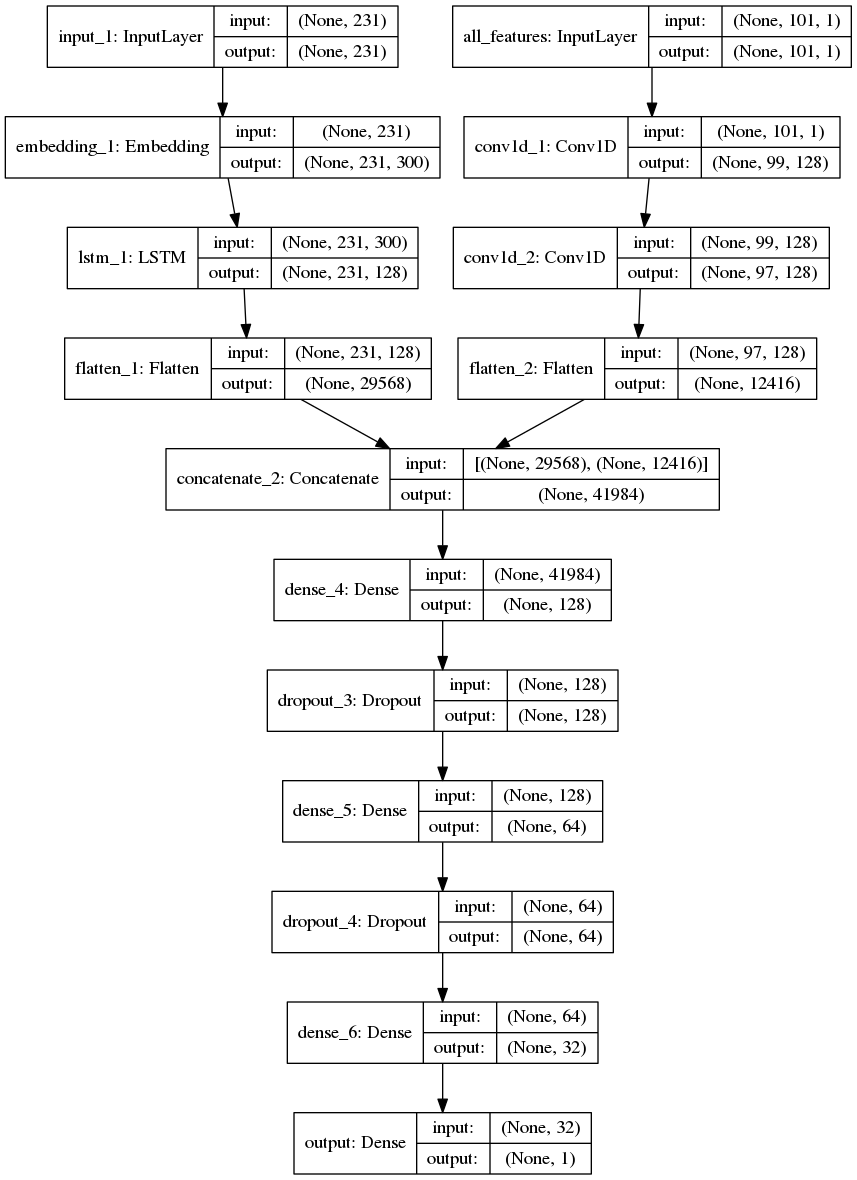

In [96]:
plot_model(model_3, show_shapes=True, show_layer_names=True, to_file='model_3.png')
Image(retina=True, filename='model_3.png')

In [42]:
%%notify

model_3.fit([padded_docs_train, X_train], [y_train],
            epochs=20,
            batch_size=1024,
            validation_data=([padded_docs_CV, X_CV], [y_CV]),
            callbacks=[ival, tb])

Train on 69918 samples, validate on 17480 samples
Epoch 1/20
69918/69918 [==============================] - 33s 468us/step - loss: 0.6333 - acc: 0.8498 - val_loss: 0.5330 - val_acc: 0.8559
********************** Epoch: 1 AUC:  0.7512240604313607 *********************
Epoch 2/20
69918/69918 [==============================] - 31s 444us/step - loss: 0.4995 - acc: 0.8575 - val_loss: 0.4862 - val_acc: 0.8551
********************** Epoch: 2 AUC:  0.7503047164363255 *********************
Epoch 3/20
69918/69918 [==============================] - 31s 440us/step - loss: 0.4616 - acc: 0.8579 - val_loss: 0.4622 - val_acc: 0.8581
********************** Epoch: 3 AUC:  0.7485465011878258 *********************
Epoch 4/20
69918/69918 [==============================] - 31s 442us/step - loss: 0.4398 - acc: 0.8590 - val_loss: 0.4443 - val_acc: 0.8550
********************** Epoch: 4 AUC:  0.749396082473042 *********************
Epoch 5/20
69918/69918 [==============================] - 31s 440us/step - loss

<IPython.core.display.Javascript object>

**Model 2: Training loss**

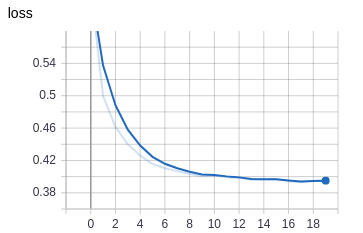

In [43]:
from IPython.display import Image
Image('model_3_training_loss.png')

**Model 3: validation loss**

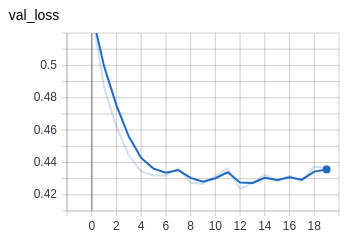

In [46]:
Image('model_3_validation_loss.png')

# Concluding Remarks

* We tried out 3 different Neaural net models for this classification problem. The first two models had the same architecture, but varying number of essay features and used LSTMs.

* We used Tensorboard to analyze how the loss function varies with each epoch.

* Used Keras callbacks to print a custom metric (AUC) after each epoch. 

* The best AUC observed was ~0.76.